In [ ]:
%pip install pandas numpy matplotlib seaborn statsmodels scikit-learn prophet tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# load dataset

df = pd.read_csv('train.csv')
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
df = df[['Order Date', 'Sales']]
df = df.groupby('Order Date').sum().asfreq('D')
df = df.dropna()  # Drop rows with missing values

In [ ]:
train_size = int(len(df) * 0.75)
train, test = df[:train_size], df[train_size:]

In [ ]:
model_arima = ARIMA(train, order=(6, 0, 0))
fit_arima = model_arima.fit()
pred_arima = fit_arima.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [ ]:
model_sarima = SARIMAX(train, order=(0, 0, 0), seasonal_order=(1, 1, 0, 12))
fit_sarima = model_sarima.fit()
pred_sarima = fit_sarima.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
model_es = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12)
fit_es = model_es.fit()
pred_es = fit_es.forecast(len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
prophet_df = train.reset_index()[['Order Date', 'Sales']].rename(columns={'Order Date': 'ds', 'Sales': 'y'})
model_prophet = Prophet()
model_prophet.fit(prophet_df)
future = model_prophet.make_future_dataframe(periods=len(test))
forecast = model_prophet.predict(future)
pred_prophet = forecast['yhat'].iloc[-len(test):].values

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20fid101/46rx6psu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20fid101/0o7h08cn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20194', 'data', 'file=/tmp/tmp20fid101/46rx6psu.json', 'init=/tmp/tmp20fid101/0o7h08cn.json', 'output', 'file=/tmp/tmp20fid101/prophet_modeloxjdg0t1/prophet_model-20250406192252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:22:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:22:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Sales']])

X, y = [], []
for i in range(60, len(scaled)):
    X.append(scaled[i-60:i])
    y.append(scaled[i])
X, y = np.array(X), np.array(y)

X_train, X_test = X[:train_size-60], X[train_size-60:]
y_train, y_test = y[:train_size-60], y[train_size-60:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
pred_lstm = model_lstm.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0072
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0049
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0060
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0053
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0056
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0053
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0057
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0057
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0057
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0050
Epoch 14/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0054
Epoch 15/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0048
Epoch 16/20
27/

In [ ]:
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
pred_cnn = model_cnn.predict(X_test)
pred_cnn = scaler.inverse_transform(pred_cnn)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'MAPE'])

results.loc[len(results)] = ['ARIMA', *evaluate(test['Sales'].values, pred_arima)]
results.loc[len(results)] = ['SARIMA', *evaluate(test['Sales'].values, pred_sarima)]
results.loc[len(results)] = ['Exp Smoothing', *evaluate(test['Sales'].values, pred_es)]
results.loc[len(results)] = ['Prophet', *evaluate(test['Sales'].values, pred_prophet)]
results.loc[len(results)] = ['LSTM', *evaluate(y_test_actual.flatten(), pred_lstm.flatten())]
results.loc[len(results)] = ['CNN', *evaluate(y_test_actual.flatten(), pred_cnn.flatten())]

results.set_index('Model', inplace=True)
results

,MSE,RMSE,MAE,MAPE
Model,,,,
ARIMA,6.151248e+06,2480.170996,1643.251254,586.736070
SARIMA,7.802622e+06,2793.317425,2024.934979,642.433415
Exp Smoothing,5.840266e+06,2416.664128,1871.235746,877.952526
Prophet,5.716846e+06,2390.992723,1687.615292,649.983940
LSTM,5.703577e+06,2388.216200,1641.243793,672.563263
CNN,5.983477e+06,2446.114579,1683.932359,607.335838


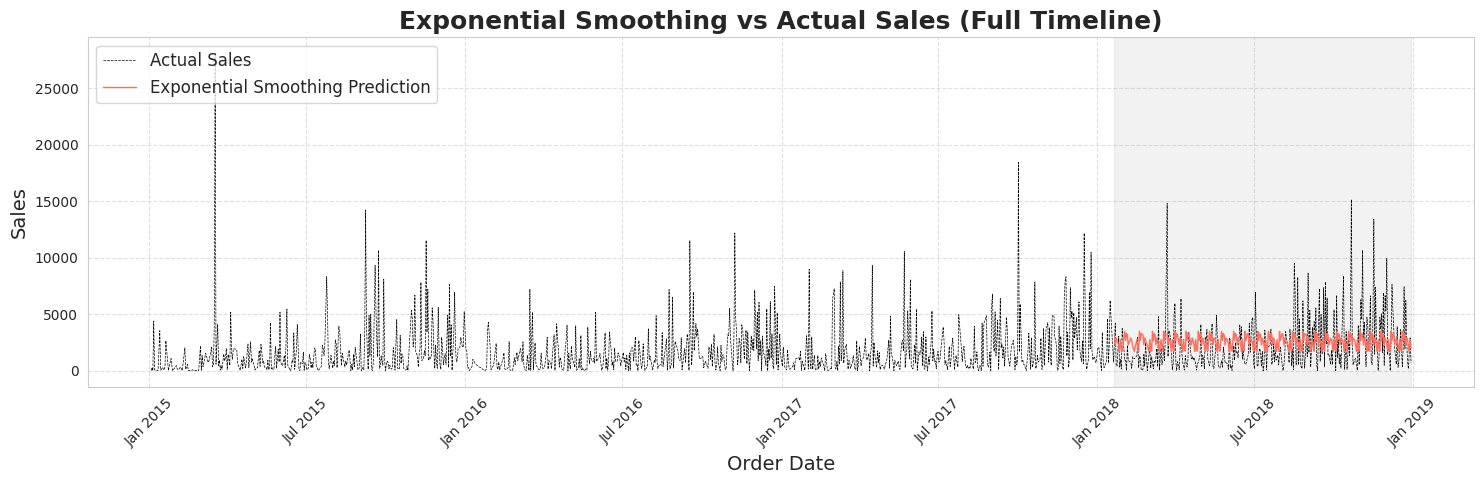

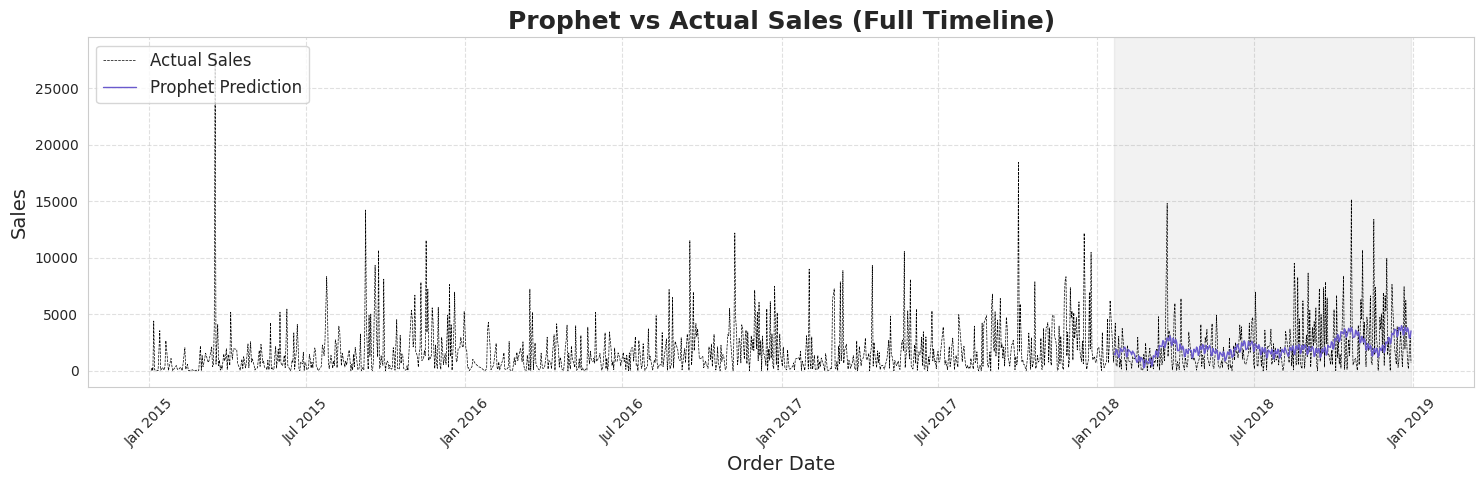

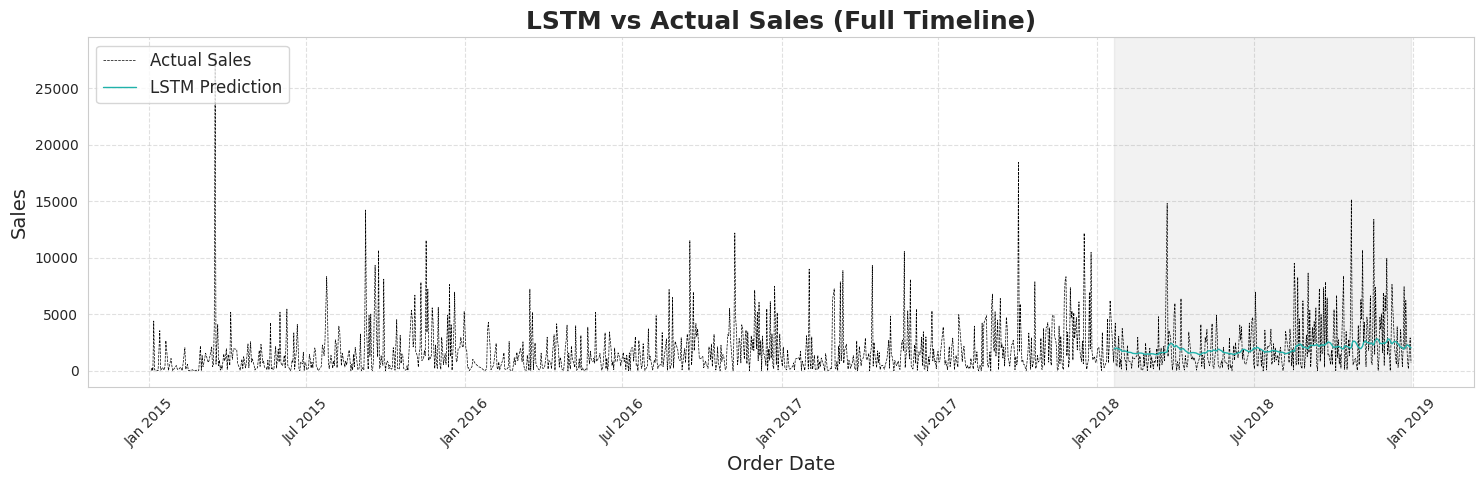

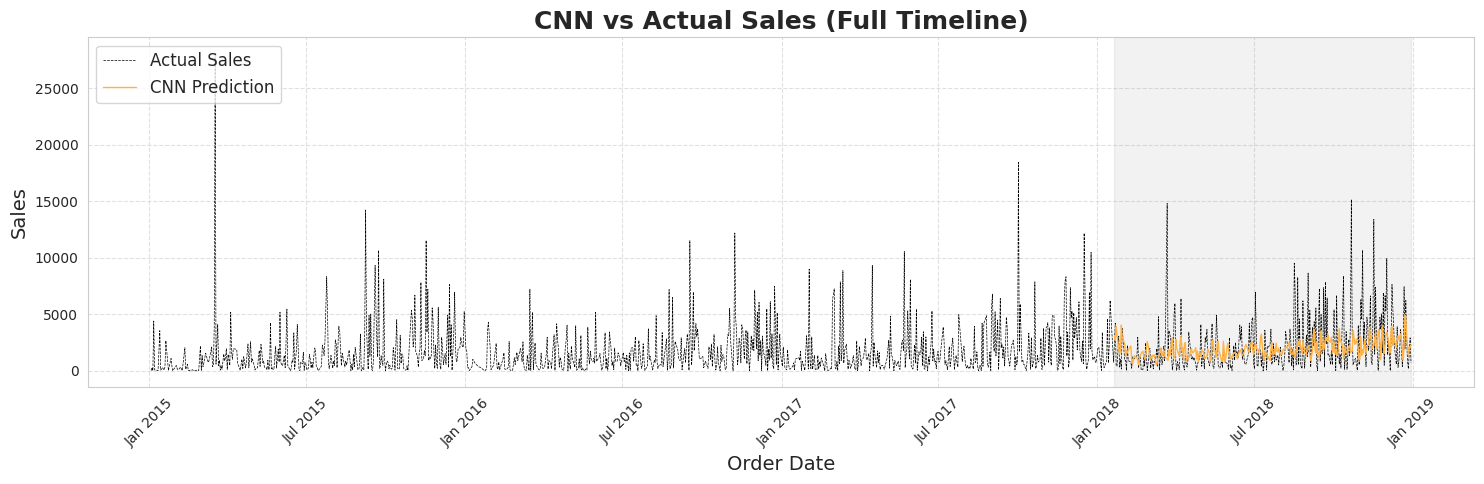

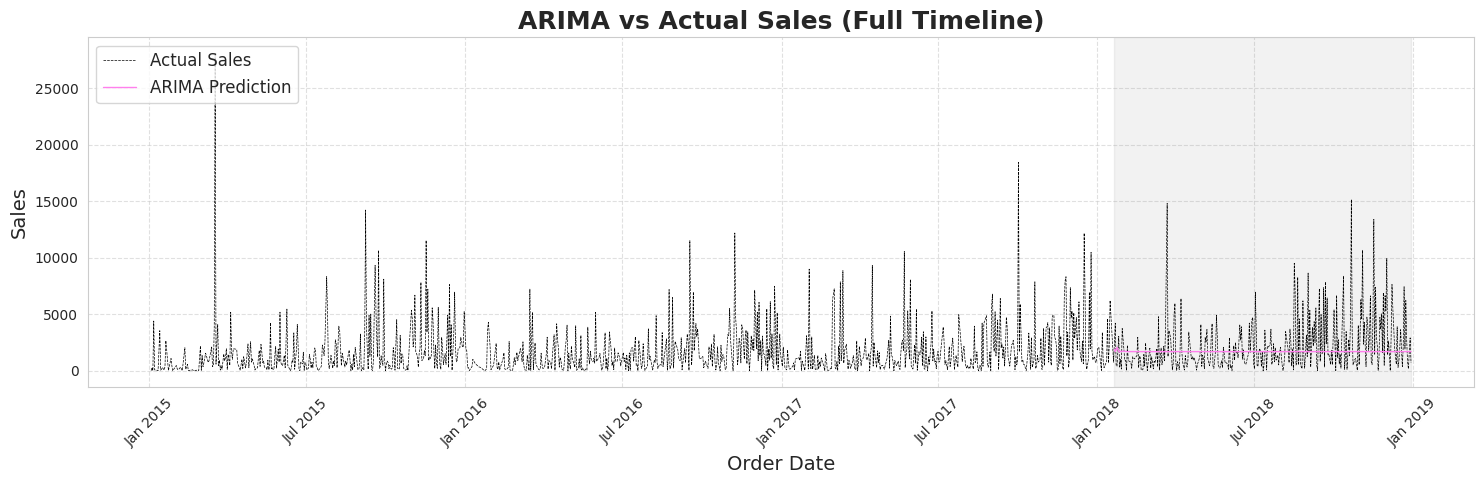

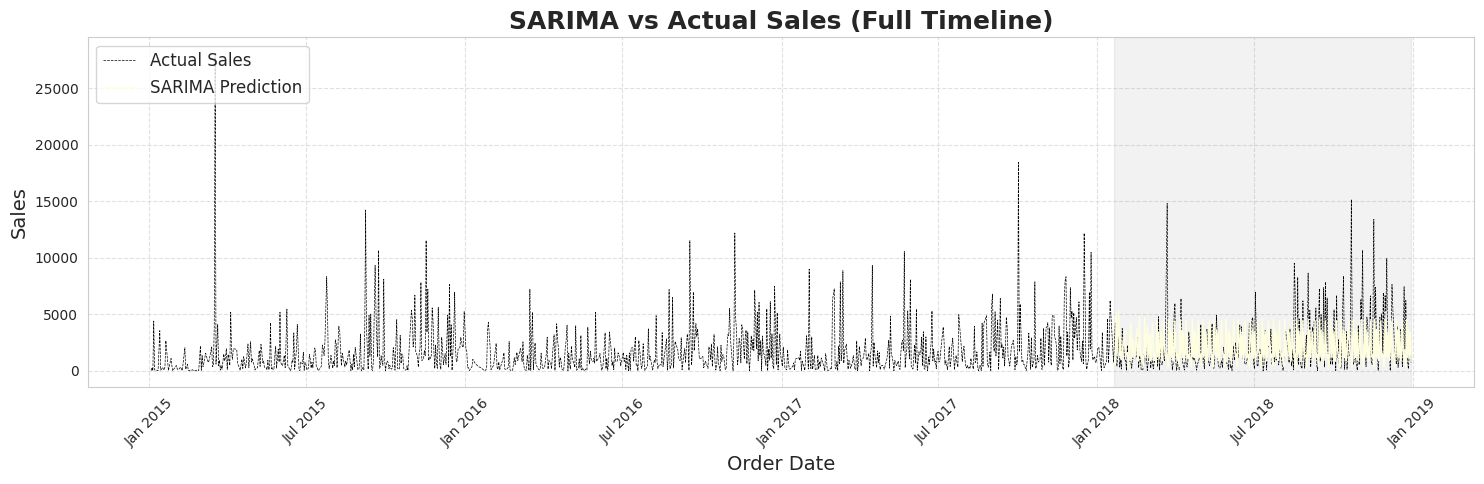

In [ ]:
import matplotlib.dates as mdates

# Set a colorful Seaborn style
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 13,
    'legend.fontsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Dates from test set
dates = test.index

# Mapping model names to their predictions
model_predictions = {
    'Exponential Smoothing': pred_es,
    'Prophet': pred_prophet,
    'LSTM': pred_lstm,
    'CNN': pred_cnn,
    'ARIMA' : pred_arima,
    'SARIMA' : pred_sarima
}

# Color palette for fun
colors = {
    'Exponential Smoothing': '#ff6f61',
    'Prophet': '#6a5acd',
    'LSTM': '#20b2aa',
    'CNN': '#ffb347',
    'ARIMA': '#ff80ed',
    'SARIMA': '#FFFFE0'
}

# Plot each model
for model_name, prediction in model_predictions.items():
    plt.figure(figsize=(15, 5))
    sns.set_style("whitegrid")

    # Plot full actual sales timeline
    plt.plot(df.index, df['Sales'], label='Actual Sales', color='black', linewidth=0.5, linestyle = '--')

    # Overlay model's prediction only on test range
    plt.plot(test.index, prediction, label=f'{model_name} Prediction', color=colors[model_name], linewidth=1)

    # Title & labels
    plt.title(f'{model_name} vs Actual Sales (Full Timeline)', fontsize=18, fontweight='bold')
    plt.xlabel('Order Date', fontsize=14)
    plt.ylabel('Sales', fontsize=14)

    # Date formatting
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    # Legend and layout
    plt.legend(loc='upper left', fontsize=12, frameon=True, facecolor='white')
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.1, label='Test Period')
    plt.show()


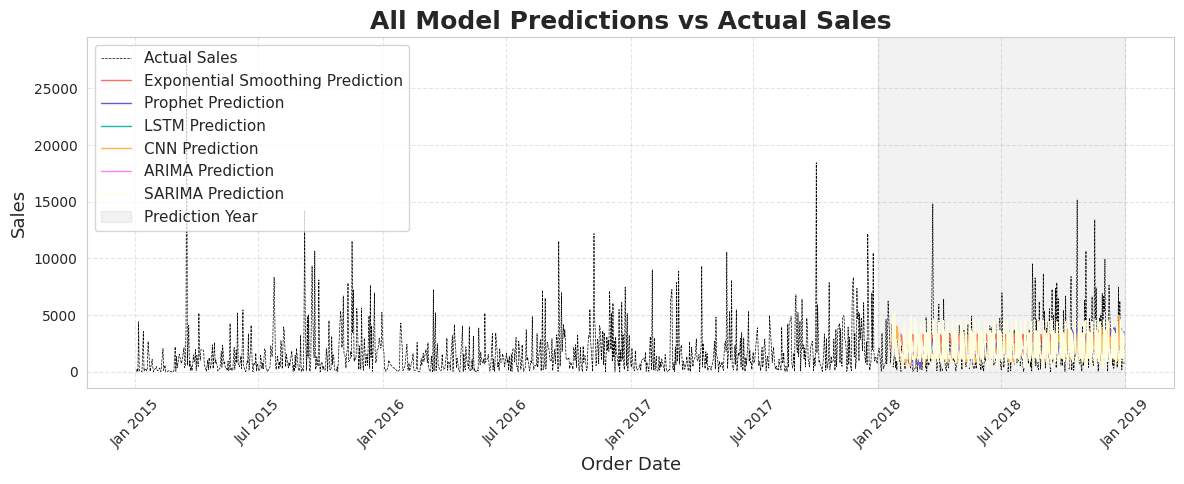

In [ ]:
plt.figure(figsize=(12, 5))

# Plot all actual sales across all years
plt.plot(df.index, df['Sales'], label='Actual Sales', color='black', linewidth=0.5, linestyle='--')

# Plot each model’s prediction ONLY during test period
for model_name, prediction in model_predictions.items():
    plt.plot(test.index, prediction, label=f'{model_name} Prediction',
             color=colors[model_name], linewidth=1)

# Optional: highlight the prediction year with shading (e.g., 2020)
plt.axvspan(pd.Timestamp('2018-01-01'), pd.Timestamp('2018-12-31'),
            color='grey', alpha=0.1, label='Prediction Year')

# Formatting
plt.title('All Model Predictions vs Actual Sales', fontsize=18, fontweight='bold')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend(loc='upper left', frameon=True, facecolor='white')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
